# Credit Card Fraud Detection classifier using a Neural network in PyTorch

## About the dataset

#### The dataset contains transactions made by credit cards in September 2013 by European cardholders.

#### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

#### It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, they didn't provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

#### Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. 
#### The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
#### Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

## EDA

In [1]:
# Importing the libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# Importing the dataset
df = pd.read_csv('CreditCardDataset.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
1,2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
2,7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
3,11,1.069374,0.287722,0.828613,2.712520,-0.178398,0.337544,-0.096717,0.115982,-0.221083,...,-0.036876,0.074412,-0.071407,0.104744,0.548265,0.104094,0.021491,0.021293,27.50,0
4,12,-0.752417,0.345485,2.057323,-1.468643,-1.158394,-0.077850,-0.608581,0.003603,-0.436167,...,0.499625,1.353650,-0.256573,-0.065084,-0.039124,-0.087086,-0.180998,0.129394,15.99,0


In [3]:
# Size of the dataset
print(df.shape)

(57355, 31)


In [4]:
# Missing values
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
df.dtypes

Time        int64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

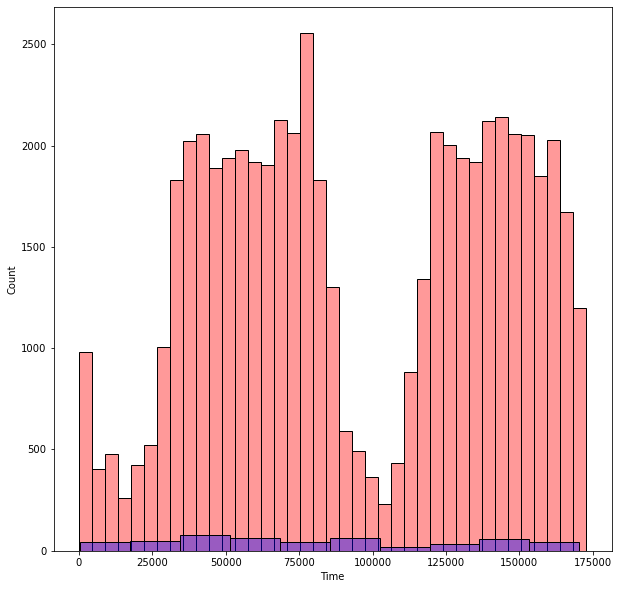

In [6]:
df_class_0=df[df.Class==0]
df_class_1=df[df.Class==1]
fig,ax = plt.subplots(figsize=(10,10))
for a,c in zip([df_class_0,df_class_1],['r','b']):
    sns.histplot(data=a,x='Time',ax=ax,color=c,alpha=0.4)

We can see that the time taken for both type of transactions is same.Time is not a parameter on which the class of transaction depend

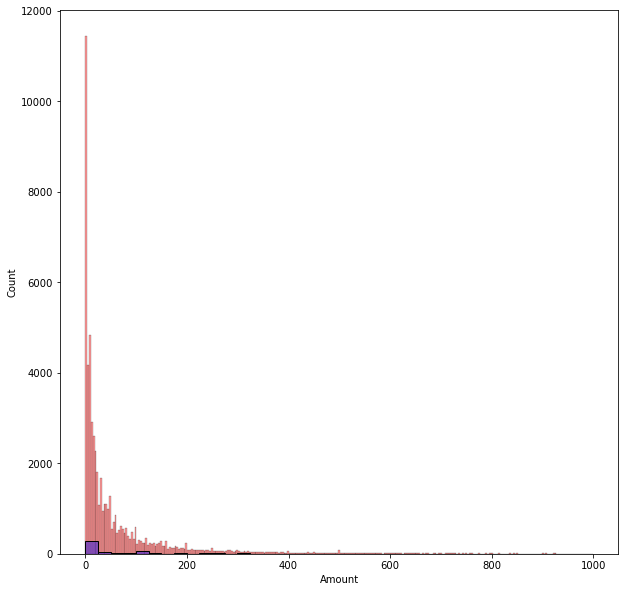

In [7]:
fig,ax = plt.subplots(figsize=(10,10))

for a,c in zip([df_class_0[df_class_0.Amount<1000],df_class_1[df_class_1.Amount<1000]],['r','b']):
    sns.histplot(data=a,x='Amount',ax=ax,color=c,alpha=0.4)

<AxesSubplot:>

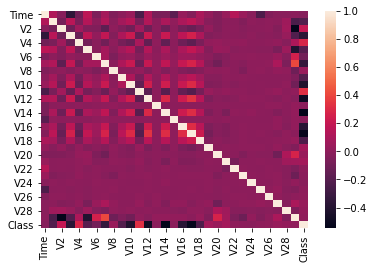

In [8]:
sns.heatmap(df.corr())

In [9]:
df.Amount.describe()

count    57355.000000
mean        88.825575
std        279.496913
min          0.000000
25%          5.475000
50%         21.990000
75%         76.900000
max      25691.160000
Name: Amount, dtype: float64

In [10]:
df.Amount.quantile(q=0.99)
# We see that for nearly 99% transactions the amount is almost 1000

1000.1184

## NN using PyTorch

In [11]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils

In [12]:
X = df.iloc[:, :-1].values # extracting features
y = df.iloc[:, -1].values # extracting labels

In [13]:
# Scaling and Preprocessing
sc = StandardScaler()
X = sc.fit_transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [15]:
class FraudNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(30, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 5)
        self.fc5 = nn.Linear(5, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

In [16]:
net = FraudNet().double()

In [17]:
net

FraudNet(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=5, bias=True)
  (fc5): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train).double()
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test).double()

In [19]:
loss_fn = nn.BCELoss() # using of Binary Cross Entropy loss as this has two labels.
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [20]:
training_epochs = 20
minibatch_size = 1000

In [21]:
train = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train, batch_size=minibatch_size, shuffle=True)

test = data_utils.TensorDataset(X_test, y_test)
test_loader = data_utils.DataLoader(test, batch_size=minibatch_size, shuffle=True)

In [22]:
train_loss=[]
test_loss=[]
train_accuracy=[]
test_accuracy=[]

for i in range(training_epochs):
    
    train_correct = 0
    train_total = 0
    
    for b, data in enumerate(train_loader, 0):
        inputs, labels = data
        y_pred = net(inputs)
        labels = labels.unsqueeze(1)
        loss = loss_fn(y_pred, labels)
        
        if b % 100:
            print('Epochs: {}, batch: {} loss: {}'.format(i, b, loss))
        #reset gradients
        optimizer.zero_grad()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        _, predicted = torch.max(y_pred.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels.data).sum()
             
    train_loss.append(loss.data)
    train_accuracy.append(((train_correct/train_total)/10))

Epochs: 0, batch: 1 loss: 0.6371800530943492
Epochs: 0, batch: 2 loss: 0.6338754626233241
Epochs: 0, batch: 3 loss: 0.6294596093344157
Epochs: 0, batch: 4 loss: 0.6260482210424223
Epochs: 0, batch: 5 loss: 0.6220126057678348
Epochs: 0, batch: 6 loss: 0.6166875816737653
Epochs: 0, batch: 7 loss: 0.6129559675641558
Epochs: 0, batch: 8 loss: 0.6096071458447907
Epochs: 0, batch: 9 loss: 0.6041920342370556
Epochs: 0, batch: 10 loss: 0.6001014017562816
Epochs: 0, batch: 11 loss: 0.5956251142226234
Epochs: 0, batch: 12 loss: 0.5872618334459344
Epochs: 0, batch: 13 loss: 0.5838164017121774
Epochs: 0, batch: 14 loss: 0.5746851434754363
Epochs: 0, batch: 15 loss: 0.5696866844956883
Epochs: 0, batch: 16 loss: 0.5622500259983059
Epochs: 0, batch: 17 loss: 0.555722481225402
Epochs: 0, batch: 18 loss: 0.5476176393356995
Epochs: 0, batch: 19 loss: 0.5418377576274348
Epochs: 0, batch: 20 loss: 0.5327680833053529
Epochs: 0, batch: 21 loss: 0.5229083853497662
Epochs: 0, batch: 22 loss: 0.516116233888563

In [23]:
with torch.no_grad():
    for i in range(training_epochs):
        test_correct = 0
        test_total = 0
        
        for data in test_loader:
            inputs, labels = data
            outputs = net(inputs)
            labels = labels.unsqueeze(1)
            loss = loss_fn(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted.double() == labels.data).sum()
            
        test_loss.append(loss.data)
        test_accuracy.append(((test_correct/test_total)/10))

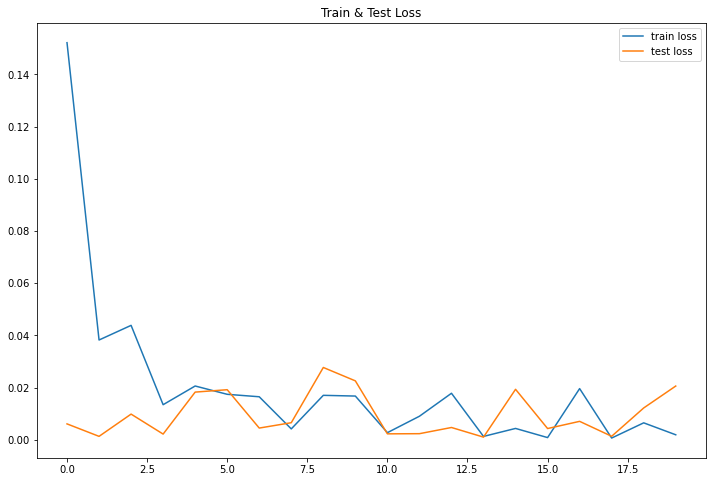

In [24]:
fig = plt.figure(figsize=(12,8))
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.title('Train & Test Loss')
plt.legend()
plt.show()

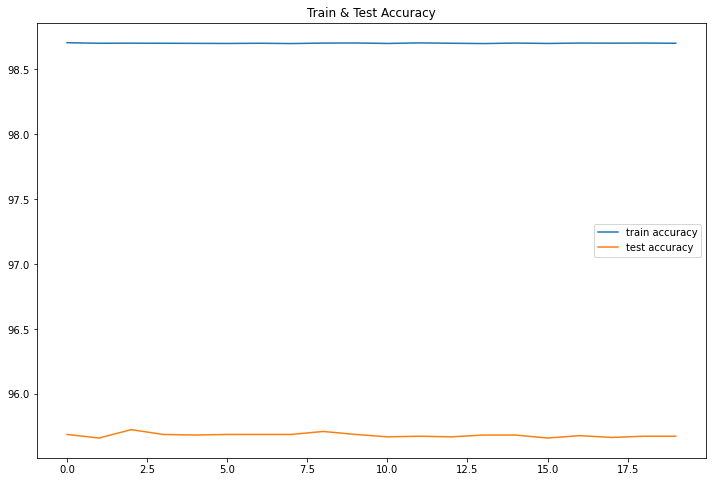

In [25]:
fig = plt.figure(figsize=(12,8))
plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.title('Train & Test Accuracy')
plt.legend()
plt.show()

### * We can assume that the model is a good fit for the dataset because the validation loss is slightly higher than the training loss.

### * When it comes to train and test accuracies, the training accuracy is about 99% and test accuracy is less than 96% 

### * We may conclude there might be important variations between the type of data I used to train the model and the testing data 

### * When we look at the dataset for real, we can see that there are still very less data for '0' credit risk, so the above argument is fulfilled.